## Read in various SST datasets to choose appropriate ones for CERESMIP-type simulations

In [1]:
"""
based on load SSTsharp_v2.py and SST_trends_GFs.ipynb
"""
import xcdat as xc
import xarray as xr
import pandas as pd
import numpy as np
import cftime 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from global_land_mask import globe
import cartopy.crs as ccrs
import cartopy
import xskillscore as xss
import nc_time_axis

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size']=12
plt.rcParams['pcolor.shading']='auto'

In [2]:
datanames = ['PCMDI-AMIP-1-1-9','NOAA-OISST-v2.0','NOAA-OISST-v2.1',
             'NOAA_ERSST_V5','COBE','COBE2',#'ERA5',
             'HadISST-1.1','HadISST-2.2','HadISST-2.3','HadSST4']#,
             # 'Vaccaro2021','CW_had4_krig_v2','CW_had4sst4_krig_v2']
# not considering HadISST-2.3 because it is vaporware
# not considering HadSST4 because it is an anomaly field, is low-res, and has lots of missing data
COLORS,LINES = {},{}
COLORS['PCMDI-AMIP-1-1-9'],LINES['PCMDI-AMIP-1-1-9'] =       'k','-'
COLORS['NOAA-OISST-v2.0'],LINES['NOAA-OISST-v2.0'] =         'C3','-'
COLORS['NOAA-OISST-v2.1'],LINES['NOAA-OISST-v2.1'] =         'C3','--'
COLORS['NOAA_ERSST_V5'],LINES['NOAA_ERSST_V5'] =             'C4','-'
COLORS['COBE'],LINES['COBE'] =                               'C0','-'
COLORS['COBE2'],LINES['COBE2'] =                             'C0','--'
COLORS['ERA5'],LINES['ERA5'] =                               'C2','-'
COLORS['Vaccaro2021'],LINES['Vaccaro2021'] =                 'C6','-'
COLORS['CW_had4_krig_v2'],LINES['CW_had4_krig_v2'] =         'C7','-'
COLORS['CW_had4sst4_krig_v2'],LINES['CW_had4sst4_krig_v2'] = 'C7','--'
COLORS['HadISST-1.1'],LINES['HadISST-1.1'] =                 'C1','-'
COLORS['HadISST-2.2'],LINES['HadISST-2.2'] =                 'C1', '--'
COLORS['HadISST-2.3'],LINES['HadISST-2.3'] =                 'C1', ':'
COLORS['HadSST4'],LINES['HadSST4'] =                         'C1', '-.'
COLORS['Dataset_Mean'],LINES['Dataset_Mean'] =               'k','-'

PCMDI-AMIP-1-1-9
  lat x lon = [1.] x [1.]
  start yr - end yr = 1870-2022


2025-02-27 16:43:01,751 [WARNING]: dataset.py(decode_time:360) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.
2025-02-27 16:43:01,751 [WARNING]: dataset.py(decode_time:360) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


NOAA-OISST-v2.0
  lat x lon = [1.] x [1.]
  start yr - end yr = 1981-2023
NOAA-OISST-v2.1
  lat x lon = [0.25] x [0.25]
  start yr - end yr = 1981-2023


2025-02-27 16:43:11,920 [WARNING]: dataset.py(decode_time:360) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.
2025-02-27 16:43:11,920 [WARNING]: dataset.py(decode_time:360) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


NOAA_ERSST_V5
  lat x lon = [2.] x [2.]
  start yr - end yr = 1854-2023


2025-02-27 16:43:19,095 [WARNING]: dataset.py(decode_time:360) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.
2025-02-27 16:43:19,095 [WARNING]: dataset.py(decode_time:360) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


COBE
  lat x lon = [1.] x [1.]
  start yr - end yr = 1891-2023


2025-02-27 16:43:27,510 [WARNING]: dataset.py(decode_time:360) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.
2025-02-27 16:43:27,510 [WARNING]: dataset.py(decode_time:360) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


COBE2
  lat x lon = [1.] x [1.]
  start yr - end yr = 1850-2019
HadISST-1.1
  lat x lon = [1.] x [0.5  0.75 1.  ]
  start yr - end yr = 1870-2023
HadISST-2.2
  lat x lon = [1.] x [1.]
  start yr - end yr = 1948-2015
HadISST-2.3
  lat x lon = [1.] x [0.5  0.75 1.  ]
  start yr - end yr = 1850-2020
HadSST4
  lat x lon = [5.] x [2.5  3.75 5.  ]
  start yr - end yr = 1850-2023


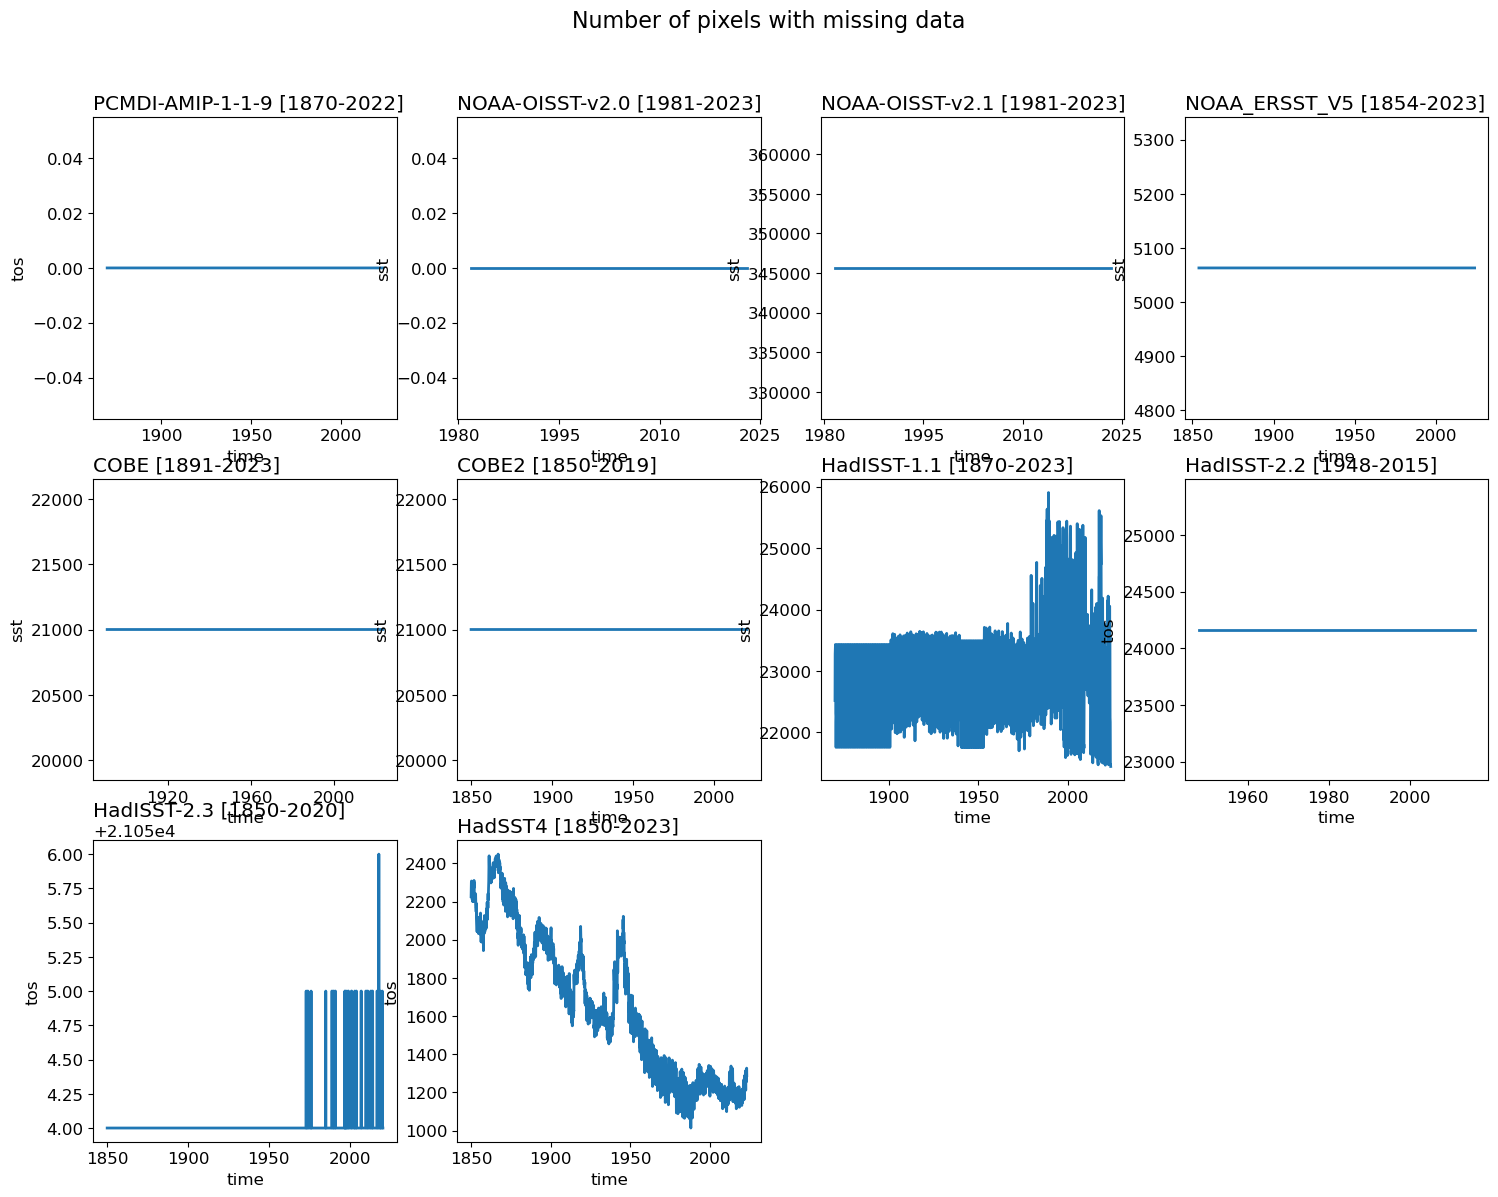

In [3]:
path = '/p/user_pub/PCMDIobs/obs4MIPs_input/'
plt.figure(figsize=(18,18))
plt.suptitle('Number of pixels with missing data',y=0.94,fontsize=16)
cnt=0
DATA={}
VARS={}
for dataname in datanames:
    cnt+=1
    if dataname == 'NOAA-OISST-v2.1': # updated 4/27/23
        filename = path+'NOAA-PSL/OISST2-1/v20230526/OISST.2.1.sst.mon.mean.nc'
        offset=0
        var='sst'
        start = '1982-01-01'
    if dataname == 'NOAA-OISST-v2.0':
        filename = path+'NOAA-PSL/OISST2-0/v20230526/OISST.2.0.sst.mnmean.nc'
        offset=0
        var='sst'
        start = '1982-01-01'
    if dataname == 'COBE': # updated 4/27/23
        filename = path+'NOAA-PSL/COBE1/v20230526/COBE.1.sst.mon.mean.nc'
        offset=0
        var='sst'
    if dataname == 'COBE2': # updated 4/27/23
        filename = path+'NOAA-PSL/COBE2/v20230526/COBE.2.sst.mon.mean.nc'
        offset=0
        var='sst'       
    if dataname == 'NOAA_ERSST_V5': 
        filename = path+'NOAA-PSL/ERSST5/v20231110/ERSST.5.sst.mnmean.nc'
        offset=0
        var='sst'
    if dataname == 'HadISST-1.1': 
        filename = path+'MOHC/HadISST1-1/v20231114/HadISST.1.1.sst.nc'
        offset=0
        var='sst'
    if dataname == 'HadISST-2.2':
        filename = '/p/user_pub/climate_work/zelinka1/HadISST/HadISST-2-2-0-0-0.nc'
        offset=0
        var='tos'
    if dataname == 'HadISST-2.3':
        filename = path+'MOHC/HadISST2-3/v20230526/HadISST.2.3.0.c_ensemble_member_001.nc' # note that there are 20 members here
        offset = -273.15 # this dataset is reported in K
        var='tos'
    if dataname == 'HadSST4':
        filename = path+'MOHC/HadSST4-0/v20230526/HadSST.4.0.1.0_median.nc'
        offset=0
        var='tos'
    if dataname == 'ERA5': # updated 4/27/23
        filename = '/p/user_pub/climate_work/zelinka1/ERA5/ts_mon_ERA5_197901-202212.nc'
        offset = -273.15 # this dataset is reported in K
        var='skt'
    if dataname == 'PCMDI-AMIP-1-1-9': # input4MIPs
        filename = '/p/user_pub/work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9/ocean/mon/tos/gn/v20230512/tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc'
        offset=0
        var='tos'
    if dataname == 'PCMDI-BCS': # input4MIPs
        filename = '/p/user_pub/work/input4MIPs/CMIP6/CMIP/PCMDI/PCMDI-AMIP-1-1-8/ocean/mon/tosbcs/gn/v20220622/tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-8_gn_187001-202112.nc'
        offset=0
        var='tosbcs'
    if dataname == 'CW_had4_krig_v2':
        filename = '/p/user_pub/climate_work/zelinka1/pattern-effectMIP/Cowtan_Way2014/had4_krig_v2/had4_krig_v2_T63_bil_absolute_TS_values01.nc'
        offset=0
        var = 'temperature_anomaly'
    if dataname == 'CW_had4sst4_krig_v2':
        filename = '/p/user_pub/climate_work/zelinka1/pattern-effectMIP/Cowtan_Way2014/had4sst4_krig_v2/had4sst4_krig_v2_T63_bil_absolute_TS_values01.nc'
        offset=0
        var = 'temperature_anomaly'
    if dataname == 'Vaccaro2021':
        filename = '/p/user_pub/climate_work/zelinka1/pattern-effectMIP/Vaccaro_et_al_2021/vaccaro_et_al_2021_T63_bil_absolute_TS_values01.nc'
        offset=0
        var = 'temperature_anomaly'

    ds = xc.open_mfdataset(filename, use_cftime = True, lon_orient=(0, 360))
    
    if dataname == 'Vaccaro2021':    
        ds['time'] = pd.date_range(start="1850-01-15", end="2017-12-31", freq='M')
    
    try:
        ds.lat
        data0 = ds#.sel(time=slice(start,end))
    except:
        data = ds.rename({'longitude': 'lon'})
        data0 = data.rename({'latitude': 'lat'})

    # Ensure lats go from S to N
    if data0.lat[0]>0:
        data = data0.reindex(lat=list(reversed(data0.lat)))
    else:
        data = data0    
    lat = np.array(data.lat)
    lon = np.array(data.lon)    
    
    OBSdata = data[var].squeeze().compute() + offset
    OBSdata = xr.where(OBSdata<-100,np.nan,OBSdata)        
    
    missing = OBSdata.isnull().sum(['lat','lon'])

    print(dataname)
    print('  lat x lon = '+str(np.unique(np.gradient(lat)))+' x '+str(np.unique(np.gradient(lon))))
    trange = str(OBSdata.time.dt.year.values[0])+'-'+str(OBSdata.time.dt.year.values[-1])
    print('  start yr - end yr = '+trange)
    
    plt.subplot(4,4,cnt)
    missing.plot()
    plt.title(dataname+' ['+trange+']',loc='left')

    DATA[dataname] = OBSdata
    VARS[dataname] = var

In [4]:
import pandas as pd
import cftime

duration={}
for dataset in DATA.keys():
    duration[dataset]={}
    t=DATA[dataset].time[0]
    duration[dataset]['start'] = str(t.dt.year.values)+'-'+str(t.dt.month.values)+'-'+str(t.dt.day.values)
    t=DATA[dataset].time[-1]
    duration[dataset]['end'] = str(t.dt.year.values)+'-'+str(t.dt.month.values)+'-'+str(t.dt.day.values)

df = pd.DataFrame(duration)
df.T

,start,end
PCMDI-AMIP-1-1-9,1870-1-16,2022-12-16
NOAA-OISST-v2.0,1981-12-1,2023-1-1
NOAA-OISST-v2.1,1981-9-1,2023-4-1
NOAA_ERSST_V5,1854-1-1,2023-10-1
COBE,1891-1-1,2023-4-1
COBE2,1850-1-1,2019-12-1
HadISST-1.1,1870-1-16,2023-9-16
HadISST-2.2,1948-1-1,2015-12-1
HadISST-2.3,1850-1-16,2020-8-16
HadSST4,1850-1-16,2023-4-16


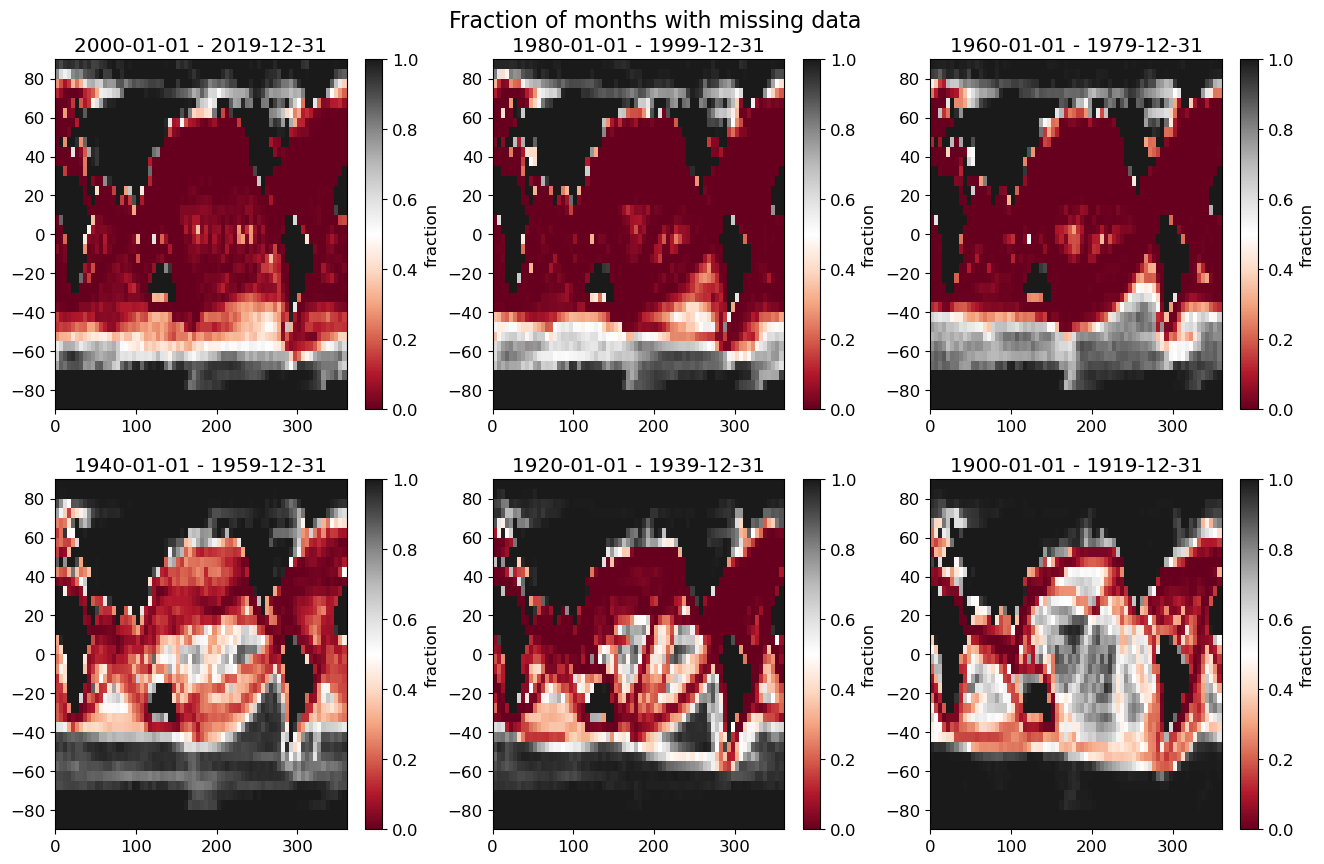

In [5]:
dataname = 'HadSST4'
plt.figure(figsize=(16,10))
plt.suptitle('Fraction of months with missing data',y=0.93,fontsize=16)
for p,endyr in enumerate([2020,2000,1980,1960,1940,1920]):
    plt.subplot(2,3,p+1)
    tslice = slice(str(endyr-20)+'-01-01',str(endyr-1)+'-12-31')
    obs=DATA[dataname].sel(time=tslice)
    denom = len(obs.time)
    numer = obs.isnull().sum('time')
    (numer/denom).plot(vmin=0,vmax=1,cmap='RdGy',cbar_kwargs={'label': 'fraction'})
    plt.xlabel('')
    plt.ylabel('')   
    plt.title(tslice.start+' - '+tslice.stop)

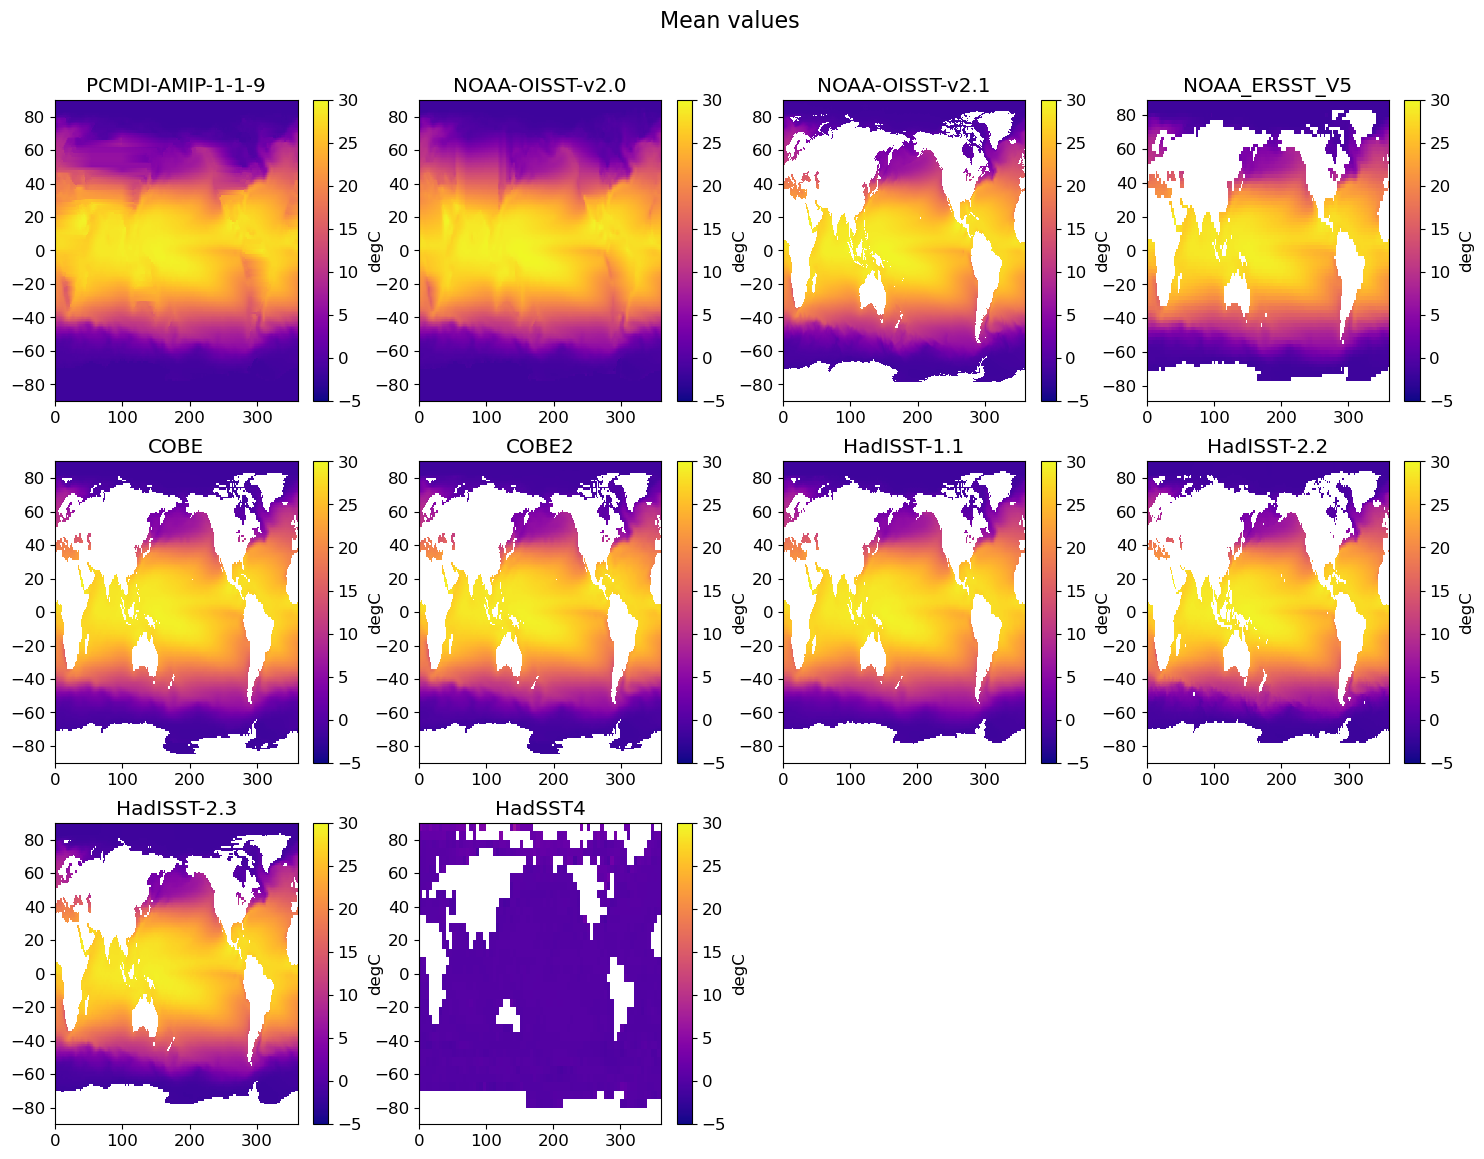

In [6]:
plt.figure(figsize=(18,18))
plt.suptitle('Mean values',y=0.93,fontsize=16)
cnt=0
for dataname in list(VARS.keys()):
    cnt+=1
    plt.subplot(4,4,cnt)
    var = VARS[dataname]
    this = DATA[dataname].mean('time')
    this.plot(vmin=-5,vmax=30,cmap='plasma',cbar_kwargs={'label': 'degC'})
    plt.title(dataname)
    plt.xlabel('')
    plt.ylabel('')

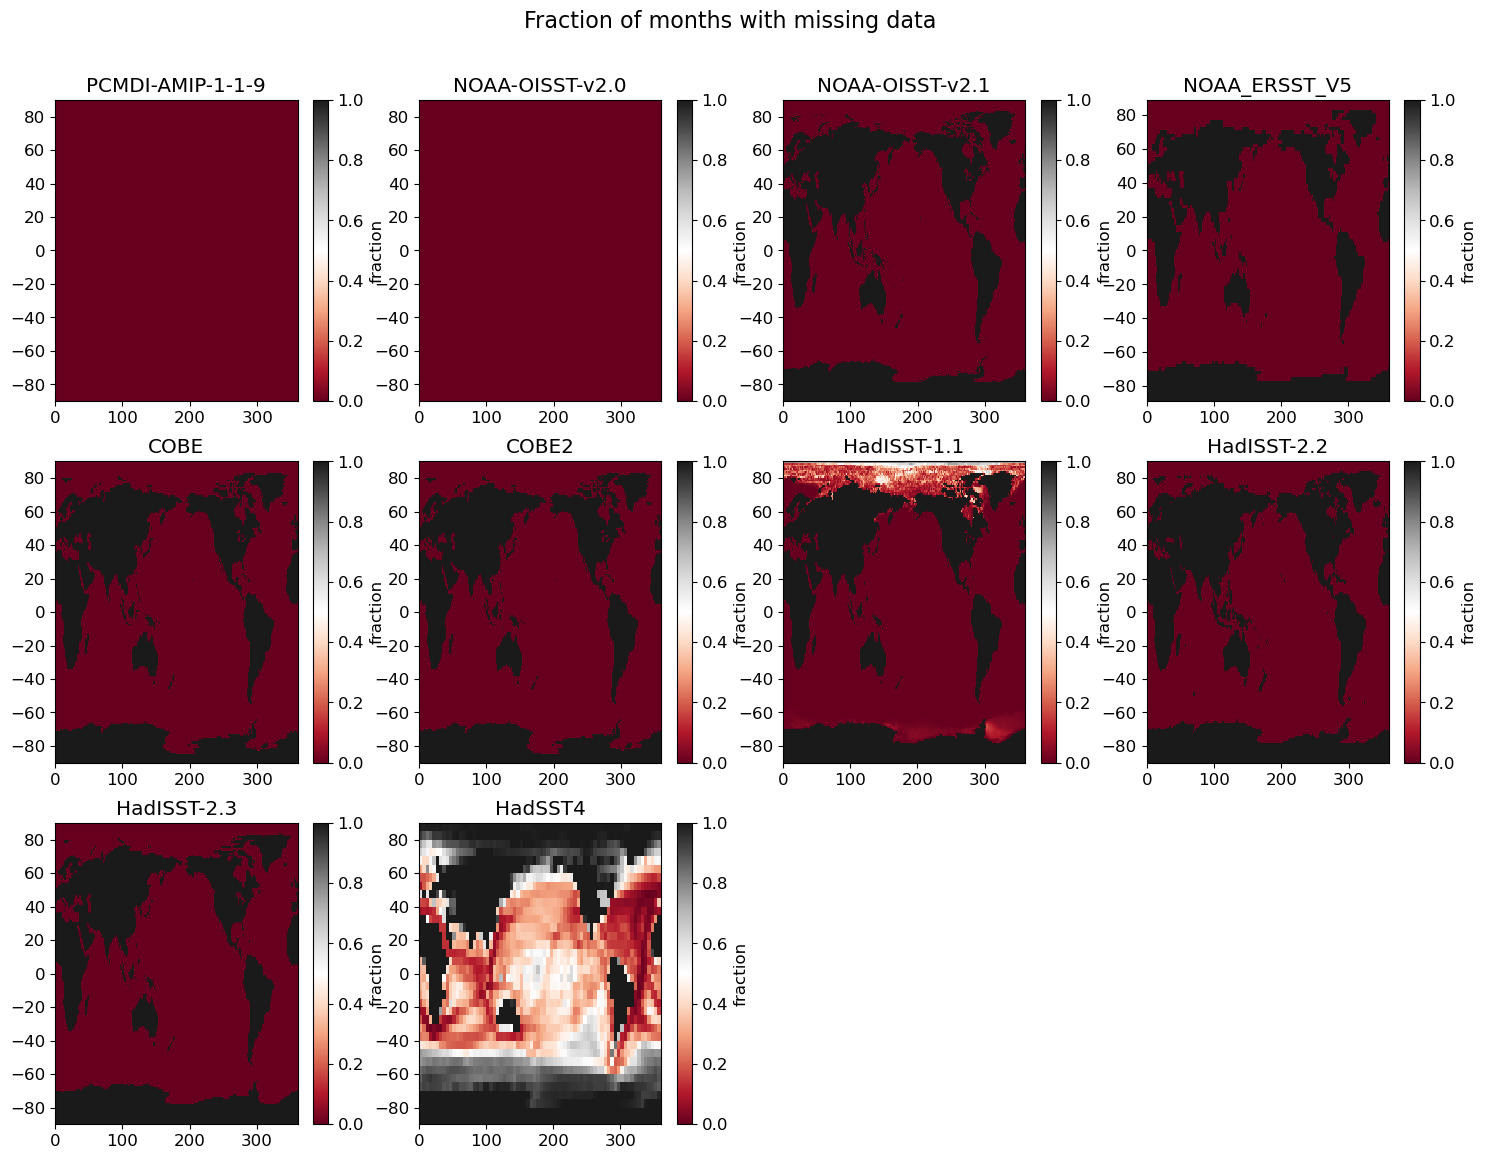

In [7]:
plt.figure(figsize=(18,18))
plt.suptitle('Fraction of months with missing data',y=0.93,fontsize=16)
cnt=0
for dataname in list(VARS.keys()):
    cnt+=1
    plt.subplot(4,4,cnt)
    var = VARS[dataname]
    denom = len(DATA[dataname].time)
    numer = DATA[dataname].isnull().sum('time')
    (numer/denom).plot(vmin=0,vmax=1,cmap='RdGy',cbar_kwargs={'label': 'fraction'})
    plt.title(dataname)
    plt.xlabel('')
    plt.ylabel('')

In [8]:
# STOP

# I want to compare OISST2.0 with PCMDI -- are they identical? Also, what does the final month of OISST2.0 look like (Jan 2023)?


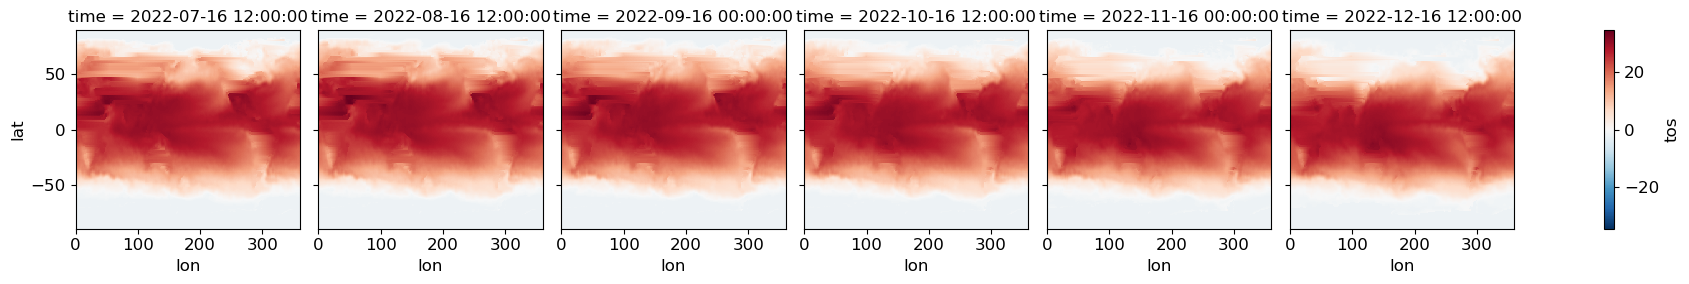

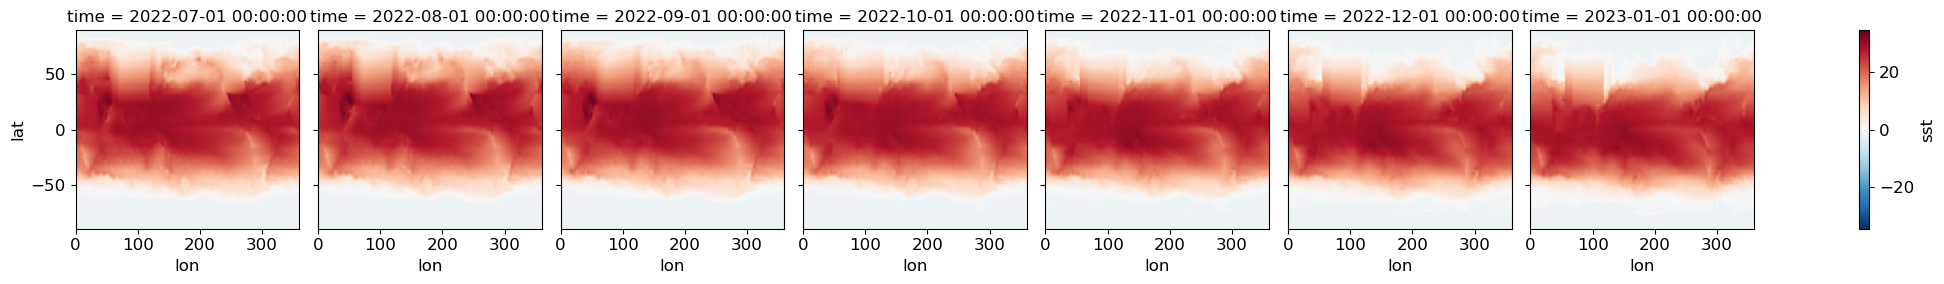

In [9]:
tslice = slice('2022-07','2023-01')
P = DATA['PCMDI-AMIP-1-1-9'].sel(time=tslice)
P.plot(col='time')

N = DATA['NOAA-OISST-v2.0'].sel(time=tslice)
N.plot(col='time')

# diff = P.to_numpy() - N.to_numpy()
# DS = xr.Dataset({'diff':(('time','lat','lon'),diff)},
# coords={'time': P.time,'lat': P.lat,'lon': P.lon}) 
# DS.lat.attrs['axis'] = 'Y'
# DS.lon.attrs['axis'] = 'X'
# DS['diff'].plot(col='time',col_wrap=6)

In [10]:
stop


NameError: name 'stop' is not defined

In [ ]:
tslice = slice('2012-01','2012-06')
P = DATA['PCMDI-AMIP-1-1-9'].sel(time=tslice)
P.plot(col='time',col_wrap=6)

N = DATA['NOAA-OISST-v2.0'].sel(time=tslice)
# N.plot(col='time',col_wrap=6)

diff = P.to_numpy() - N.to_numpy()
DS = xr.Dataset({'diff':(('time','lat','lon'),diff)},
coords={'time': P.time,'lat': P.lat,'lon': P.lon}) 
DS.lat.attrs['axis'] = 'Y'
DS.lon.attrs['axis'] = 'X'
DS['diff'].plot(col='time',col_wrap=6)

In [ ]:
plt.figure(figsize=(18,18))
plt.suptitle('Minimum value',y=0.93,fontsize=16)
cnt=0
for dataname in list(VARS.keys()):
    cnt+=1
    plt.subplot(4,4,cnt)
    this=DATA[dataname].min(['lat','lon'])
    this.plot()
    plt.title(dataname)

In [ ]:
# BCpath = '/p/user_pub/work/input4MIPs/CMIP6/CMIP/PCMDI/PCMDI-AMIP-1-1-8'
BCpath = '/p/user_pub/work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9' 
tos = xr.open_dataset(BCpath+'/ocean/mon/tos/gn/v20230512/tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc')
siconc = xr.open_dataset(BCpath+'/seaIce/mon/siconc/gn/v20230512/siconc_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc')
sftof = xr.open_dataset(BCpath+'/ocean/fx/sftof/gn/v20230512/sftof_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn.nc')
sftof['sftof'].plot()

In [ ]:
sic = siconc['siconc']
ocn = sftof['sftof']
sst = tos['tos']

lndsst = xr.where(ocn<100,sst,np.nan)
ice = xr.where(np.logical_and(sic>=90 , ocn==100),sst,np.nan) # sea ice
ocnsst = xr.where(np.logical_and(sic<90 , ocn==100),sst,np.nan)

In [ ]:
sic.isel(time=slice(-6,None)).plot(col='time',col_wrap=3)

In [ ]:
fig,ax = plt.subplots(3,3,figsize=(16,4),sharey=True)
plt.subplot(1,3,1)
lndsst.isel(time=-100).plot(vmin=-2,vmax=30)
plt.title('Land')
plt.subplot(1,3,2)
ice.isel(time=-100).plot(vmin=-2,vmax=30)
plt.title('SIC>=90%')
plt.subplot(1,3,3)
ocnsst.isel(time=-100).plot(vmin=-2,vmax=30)
plt.title('SIC<90%')

In [ ]:
ocnsst.isel(time=-100).sel(lon=150,method='nearest').plot(marker='.',ls='',label='SIC<90%')
ice.isel(time=-100).sel(lon=150,method='nearest').plot(marker='.',ls='',label='SIC>=90%')
lndsst.isel(time=-100).sel(lon=150,method='nearest').plot(marker='.',ls='',label='Land')
plt.legend()

In [ ]:
sic = siconc['siconc']
ocn = sftof['sftof']
sst = tos['tos']

sst = xr.where(np.logical_and(sic<90 , ocn==100),0,sst) # ocean
sst = xr.where(np.logical_and(sic>=90 , ocn==100),1,sst) # sea ice
sst = xr.where(ocn<100,2,sst) # land

mycmap = ListedColormap(['C0','w','k'])
plt.pcolor(sst.isel(time=-100),vmin=0,vmax=2,cmap=mycmap)
cbar = plt.colorbar()
cbar.set_ticks(ticks=[0.25, 1, 1.75], labels=['SIC<90%', 'SIC>=90%','Land'])


In [ ]:
this=[np.nan,1,2,3]
np.unique(this)

In [ ]:
# Make sure each location can be only one thing:
np.unique(sst)

## Create a new SST BC dataset containing user-specified SSTs where they exist and PCMDI-AMIP SSTs elsewhere

In [ ]:
DATA.keys()

In [ ]:
# USER INPUT:
# sstname = 'NOAA-OISST-v2.1'
# sstname = 'HadISST-1.1'
sstname = 'NOAA_ERSST_V5'

In [ ]:
# Read in the orig tos data ingested into the diddling code:
orig = xc.open_dataset('/p/user_pub/climate_work/durack1/Shared/150219_AMIPForcingData/SST_1-1-9-release/MODEL.SST.HAD187001-198110.OI198111-202301.nc')
lat = np.array(tos.lat)
lon = np.array(tos.lon)
output_grid = xc.regridder.grid.create_grid(lat=lat, lon=lon)
YR = orig.time.dt.year.values[0]
MO = orig.time.dt.month.values[0]
origstart = cftime.datetime(YR, MO, 1).strftime("%Y-%m")
YR = orig.time.dt.year.values[-1]
MO = orig.time.dt.month.values[-1]
origfinish = cftime.datetime(YR, MO, 1).strftime("%Y-%m")
orig = orig.bounds.add_missing_bounds()

# Now get the alternative SST data that will be used to update this file:
path = '/p/user_pub/PCMDIobs/obs4MIPs_input/'
if sstname == 'HadISST-1.1': 
    filename = path+'MOHC/HadISST1-1/v20231114/HadISST.1.1.sst.nc'
    offset=0
    var='sst'
    METHOD='conservative'
elif sstname == 'NOAA-OISST-v2.1':
    filename = path+'NOAA-PSL/OISST2-1/v20230526/OISST.2.1.sst.mon.mean.nc'
    offset=0
    var='sst'
    METHOD='conservative'
elif sstname == 'NOAA_ERSST_V5': 
    filename = path+'NOAA-PSL/ERSST5/v20231110/ERSST.5.sst.mnmean.nc'
    offset=0
    var='sst'
    METHOD='bilinear' # keeps things smoother when going from coarse to higher res (https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html)


ds = xc.open_mfdataset(filename, use_cftime = True)

try:
    ds.lat
    data0 = ds
except:
    data = ds.rename({'longitude': 'lon'})
    data0 = data.rename({'latitude': 'lat'})

# Take this data from no earlier than the start of the orig dataset up until the end of the orig dataset
# data0 = data0.sel(time=slice(None,origfinish))
data0 = data0.sel(time=slice(origstart,origfinish))

# REGRID TO PCMDI-AMIP GRID:
data = data0.regridder.horizontal(var, output_grid, tool='xesmf', method=METHOD, periodic=True)

# Choose the overlapping time period and re-set the time coord to match PCMDI
YR0 = data.time.dt.year.values[0]
MO0 = data.time.dt.month.values[0]
start = cftime.datetime(YR0, MO0, 1).strftime("%Y-%m")
# Subtract one month
new_month = MO0 - 1
new_year = YR0
if new_month == 0:
    new_month = 12
    new_year -= 1
startm1 = cftime.datetime(new_year, new_month, 1).strftime("%Y-%m")
YR1 = data.time.dt.year.values[-1]
MO1 = data.time.dt.month.values[-1]
finish = cftime.datetime(YR1, MO1, 1).strftime("%Y-%m")
# Add one month
new_month = MO1 + 1
new_year = YR1
if new_month == 13:
    new_month = 1
    new_year += 1
finishp1 = cftime.datetime(new_year, new_month, 1).strftime("%Y-%m")

BCtos = orig.sel(time=slice(start,finish))

OBSdata = data[var].squeeze().compute() + offset
OBSdata = xr.where(OBSdata<-100,np.nan,OBSdata)  
OBSdata['time'] = BCtos['time'] 

# create field that contains new data where it exists, and old data where it does not:
new = xr.where(OBSdata.isnull(),BCtos,OBSdata)

# concatenate SST fields: 
if finish<origfinish: # if the new dataset ends before the orig dataset, [orig]+[new]+[orig]
    BCtos1 = xr.concat((orig.sel(time=slice(None,startm1)),new),dim='time')
    merged = xr.concat((BCtos1,orig.sel(time=slice(finishp1,None))),dim='time')
else:  # if not, [orig]+[new]
    merged = xr.concat((orig.sel(time=slice(None,startm1)),new),dim='time')

merged['date'] = orig['date']
merged['datesec'] = orig['datesec']
merged['date_frac'] = orig['date_frac']
merged['time_bnds'] = orig['time_bnds']
merged['time'] = orig['time']
merged['lat'] = orig['lat']
merged['lon'] = orig['lon']
merged.SST.attrs["units"] = orig['SST'].units

In [ ]:
startm1,finishp1

## Basic checks of the original and merged dataset

In [ ]:
siconc = xc.open_dataset('/p/user_pub/climate_work/durack1/Shared/150219_AMIPForcingData/SST_1-1-9-release/MODEL.ICE.HAD187001-198110.OI198111-202301.nc')
BCpath = '/p/user_pub/work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9' 
sftof = xr.open_dataset(BCpath+'/ocean/fx/sftof/gn/v20230512/sftof_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn.nc')

In [ ]:
# reset tos to -1.8 if ice is >90%
plt.figure(figsize=(18,4))
plt.suptitle(sstname+'; Check: reset tos to -1.8 if ice is >90%?')
BINS = np.arange(-2.0,5,0.25)
plt.subplot(1,3,1)
sic = siconc['SEAICE']
ocn = sftof['sftof']
sst = orig['SST']
sst = xr.where(np.logical_and(sic>=50 , ocn==100),sst,np.nan)
_=sst.plot.hist(bins=BINS,log=True, label='sic>=50%; max[sst]='+str(sst.max().values.round(2)))
sst = orig['SST']
sst = xr.where(np.logical_and(sic>=89 , ocn==100),sst,np.nan)
_=sst.plot.hist(bins=BINS,log=True, label='sic>=89%; max[sst]='+str(sst.max().values.round(2)))
sst = orig['SST']
sst = xr.where(np.logical_and(sic>=90 , ocn==100),sst,np.nan)
_=sst.plot.hist(bins=BINS,log=True, label='sic>=90%; max[sst]='+str(sst.max().values.round(2)))
plt.legend()
plt.xlabel('SST bins [degC]')
plt.ylabel('Counts')
plt.title('original')

plt.subplot(1,3,2)
sic = siconc['SEAICE']
ocn = sftof['sftof']
sst = merged['SST']
sst = xr.where(np.logical_and(sic>=50 , ocn==100),sst,np.nan)
_=sst.plot.hist(bins=BINS,log=True, label='sic>=50%; max[sst]='+str(sst.max().values.round(2)))
sst = merged['SST']
sst = xr.where(np.logical_and(sic>=89 , ocn==100),sst,np.nan)
_=sst.plot.hist(bins=BINS,log=True, label='sic>=89%; max[sst]='+str(sst.max().values.round(2)))
sst = merged['SST']
sst = xr.where(np.logical_and(sic>=90 , ocn==100),sst,np.nan)
_=sst.plot.hist(bins=BINS,log=True, label='sic>=90%; max[sst]='+str(sst.max().values.round(2)))
plt.legend()
plt.xlabel('SST bins [degC]')
plt.ylabel('Counts')
plt.title('merged')

# Fix it: 
sic = siconc['SEAICE']
ocn = sftof['sftof']
sst = merged['SST']
merged['SST'] = xr.where(np.logical_and(sic>=90 , ocn==100),-1.8,sst)
# verify:
plt.subplot(1,3,3)
sic = siconc['SEAICE']
ocn = sftof['sftof']
sst = merged['SST']
sst = xr.where(np.logical_and(sic>=50 , ocn==100),sst,np.nan)
_=sst.plot.hist(bins=BINS,log=True, label='sic>=50%; max[sst]='+str(sst.max().values.round(2)))
sst = merged['SST']
sst = xr.where(np.logical_and(sic>=89 , ocn==100),sst,np.nan)
_=sst.plot.hist(bins=BINS,log=True, label='sic>=89%; max[sst]='+str(sst.max().values.round(2)))
sst = merged['SST']
sst = xr.where(np.logical_and(sic>=90 , ocn==100),sst,np.nan)
_=sst.plot.hist(bins=BINS,log=True, label='sic>=90%; max[sst]='+str(sst.max().values.round(2)))
plt.legend()
plt.xlabel('SST bins [degC]')
plt.ylabel('Counts')
plt.title('merged/fixed')


In [ ]:
# reset sst values < -1.8 to -1.8
plt.figure(figsize=(12,4))
plt.suptitle(sstname+'; Check: reset sst values < -1.8 to -1.8?')

plt.subplot(1,2,1)
sic = siconc['SEAICE']
ocn = sftof['sftof']
sst = orig['SST']
sst.plot.hist(bins=np.arange(-2.5,5,0.5),log=True,label='all points, min(sst) = '+str(np.round(sst.min().values,2)))
sst = orig['SST']
sst = xr.where(ocn==100,sst,np.nan)
sst.plot.hist(bins=np.arange(-2.5,5,0.5),log=True,label='excluding land, min(sst) = '+str(np.round(sst.min().values,2)))
plt.legend()
plt.xlabel('SST bins [degC]')
plt.ylabel('Counts')
plt.title('original')

plt.subplot(1,2,2)
sic = siconc['SEAICE']
ocn = sftof['sftof']
sst = merged['SST']
sst.plot.hist(bins=np.arange(-2.5,5,0.5),log=True,label='all points, min(sst) = '+str(np.round(sst.min().values,2)))
sst = merged['SST']
sst = xr.where(ocn==100,sst,np.nan)
sst.plot.hist(bins=np.arange(-2.5,5,0.5),log=True,label='excluding land, min(sst) = '+str(np.round(sst.min().values,2)))
plt.legend()
plt.xlabel('SST bins [degC]')
plt.ylabel('Counts')
plt.title('merged')

In [ ]:
tslice = slice('1979-01','2023-12')

In [ ]:
# reset ice to 0% if tos >= 5
plt.figure(figsize=(12,4))
plt.suptitle(sstname+'; Check: reset ice to 0% if tos >= 5?')

plt.subplot(1,2,1)
ocn = sftof['sftof']
sst = orig['SST']
sic = siconc['SEAICE']
sic = xr.where(np.logical_and(sst<0 , ocn==100),sic,np.nan)
sic.plot.hist(bins=np.arange(-2,102,1),log=True,label='sst<0; max[sic]='+str(sic.max().values.round(2)))
sic = siconc['SEAICE']
sic = xr.where(np.logical_and(sst>=0 , ocn==100),sic,np.nan)
sic.plot.hist(bins=np.arange(-2,102,1),log=True,label='sst>=0; max[sic]='+str(sic.max().values.round(2)))
sic = siconc['SEAICE']
sic = xr.where(np.logical_and(sst>=5 , ocn==100),sic,np.nan)
sic.plot.hist(bins=np.arange(-2,102,1),log=True,label='sst>=5; max[sic]='+str(sic.max().values.round(2)))
plt.legend()
plt.xlabel('SIC bins [degC]')
plt.ylabel('Counts')
plt.title('orig')

plt.subplot(1,2,2)
ocn = sftof['sftof']
sst = merged['SST']
sic = siconc['SEAICE']
sic = xr.where(np.logical_and(sst<0 , ocn==100),sic,np.nan)
sic.plot.hist(bins=np.arange(-2,102,1),log=True,label='sst<0; max[sic]='+str(sic.max().values.round(2)))
sic = siconc['SEAICE']
sic = xr.where(np.logical_and(sst>=0 , ocn==100),sic,np.nan)
sic.plot.hist(bins=np.arange(-2,102,1),log=True,label='sst>=0; max[sic]='+str(sic.max().values.round(2)))
sic = siconc['SEAICE']
sic = xr.where(np.logical_and(sst>=5 , ocn==100),sic,np.nan)
sic.plot.hist(bins=np.arange(-2,102,1),log=True,label='sst>=5; max[sic]='+str(sic.max().values.round(2)))
plt.legend()
plt.xlabel('SIC bins [degC]')
plt.ylabel('Counts')
plt.title('merged')

In [ ]:
# reset ice values < 15% to 0%
# reset ice values >= 0, <= 100
sic = siconc['SEAICE']
ocn = sftof['sftof']
sst = merged['SST']
sic.plot.hist(bins=np.arange(-2,102,1),log=True,label='all points, min - max = '+str(sic.min().values)+'-'+str(sic.max().values.round(2)))
sic = xr.where(ocn==100,sic,np.nan)
sic.plot.hist(bins=np.arange(-2,102,1),log=True,label='excluding land, min - max = '+str(sic.min().values)+'-'+str(sic.max().values.round(2)))
plt.legend()
plt.xlabel('SIC bins [%]')
plt.ylabel('Counts')
plt.title(sstname+'\nCheck 1: reset ice values <= 0, >= 100?\nCheck 2: reset ice values < 15% to 0%?')

## Sanity check plots of this new merged dataset

In [ ]:
startm1 = cftime.datetime(YR0-1, MO0, 1).strftime("%Y-%m")
# add one year and subtract one month
new_month = MO0 - 1
new_year = YR0 + 1
if new_month == 0:
    new_month = 12
    new_year -= 1
startp1 = cftime.datetime(new_year, new_month, 1).strftime("%Y-%m")

A = merged.SST
B = orig.SST

plt.figure(figsize=(12,9))
plt.suptitle(sstname)
plt.subplot(2,2,1)
A.sel(time=start).plot()
plt.title('a) Merged ['+start+']')
plt.subplot(2,2,2)
B.sel(time=start).plot()
plt.title('b) Original ['+start+']')
plt.subplot(2,2,3)
(A-B).sel(time=start).plot()
plt.title('Merged minus Original ['+start+']')
plt.subplot(2,2,4)
(A-B).sel(time=slice(startm1,None)).mean('lon').plot()
plt.title('Merged minus Original')

In [ ]:
# merged.SST.sel(time=slice('2014-01','2014-12')).plot(col='time',col_wrap=4)
# merged.SST.sel(time='2014-01').plot()
orig.SST.sel(time='2014-01').sel(lat=0,method='nearest').plot(marker='.',ls='')
merged.SST.sel(time='2014-01').sel(lat=0,method='nearest').plot(marker='+',ls='')
plt.subplots()
merged.SST[0,:,:].plot()

In [ ]:
tslice = slice('1900','2020')
orig2 = xr.where(ocn==100,orig,np.nan)
orig2 = orig2.bounds.add_missing_bounds()
avg = orig2.spatial.average('SST',lat_bounds=(-30,30))
y = avg['SST'].groupby('time.year').mean('time').chunk(year=-1)
y.sel(year=tslice).plot(label='original')

merged2 = xr.where(ocn==100,merged,np.nan)
merged2 = merged2.bounds.add_missing_bounds()
avg = merged2.spatial.average('SST',lat_bounds=(-30,30))
y = avg['SST'].groupby('time.year').mean('time').chunk(year=-1)
y.sel(year=tslice).plot(ls='--',label='merged ('+sstname+')')
plt.legend()
plt.title('Global Annual Mean SST',loc='left')

In [ ]:
plt.figure(figsize=(18,4))
plt.suptitle('SST trends, 1979-2014')
plt.subplot(1,3,1)
var='SST'
y = orig[var].groupby('time.year').mean('time').chunk(year=-1).sel(year=slice(1979,2014))
trend = 10*xss.linslope(y.year, y, dim='year', weights=None, keep_attrs=True)#, skipna=True # per decade
ocntrend1 = xr.where(ocn==100,trend,np.nan)
ocntrend1.plot(vmin=-0.5,vmax=0.5,cmap='RdBu_r')
plt.title('Original')

plt.subplot(1,3,2)
var='SST'
y = merged[var].groupby('time.year').mean('time').chunk(year=-1).sel(year=slice(1982,2015))
trend = 10*xss.linslope(y.year, y, dim='year', weights=None, keep_attrs=True)#, skipna=True # per decade
ocntrend2 = xr.where(ocn==100,trend,np.nan)
ocntrend2.plot(vmin=-0.5,vmax=0.5,cmap='RdBu_r')
plt.title('Merged ('+sstname+')')

plt.subplot(1,3,3)
plt.plot(ocntrend1.lat,ocntrend1.mean('lon'),label='Original')
plt.plot(ocntrend1.lat,ocntrend2.mean('lon'),label='Merged')
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('K/dec')

In [ ]:
merged.SST.sel(time=slice(startm1,startp1)).plot(col='time',col_wrap=6)

In [ ]:
(orig.SST - merged.SST).sel(time=slice(startm1,startp1)).plot(col='time',col_wrap=6)

In [ ]:
print(sstname)
stop

## Save this new dataset for ingestion into sanitize.py

In [ ]:
mdzPath = '/p/user_pub/climate_work/zelinka1/'+sstname
filename = mdzPath+'/MODEL.SST.HAD187001-198110.OI198111-202301.'+sstname+'.nc'
merged.SST.attrs["units"] = orig['SST'].units
merged.to_netcdf(filename)
print('saved '+filename)

## Next step: run sanitize.py to diddle this SST dataset

In [ ]:
sstname

In [ ]:
# Read the diddled data back in to compare:
import glob
gg=glob.glob('/p/user_pub/climate_work/zelinka1/amip/'+sstname+'/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9/*/*/*/*/*/*.nc')
for g in gg:
    print(g)

path = '/p/user_pub/climate_work/zelinka1/amip/'+sstname+'/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9/ocean/mon/'
gg=glob.glob(path+'tosbcs/gn/*/tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc')
did=xc.open_dataset(gg[0])
gg=glob.glob(path+'tos/gn/*/tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc')
predid=xc.open_dataset(gg[0])

In [ ]:
A = did.tosbcs
B = predid.tos
A.mean('lon').sel(time=slice('1981-01','2022-12')).sel(lat=60,method='nearest').plot(label='diddled')
B.mean('lon').sel(time=slice('1981-01','2022-12')).sel(lat=60,method='nearest').plot(label='pre-diddled')
plt.legend()

In [ ]:
(A-B).mean('lon').sel(time=slice('1981-01','2022-12')).sel(lat=60,method='nearest').plot()

Now, go to the machine on NERSC

mkdir /global/homes/z/zelinka1/E3SMv2/preproc/input4MIPS_data/SSTNAME/

cd to /global/homes/z/zelinka1/E3SMv2/preproc/input4MIPS_data/SSTNAME/

cp ../NOAA-OISST-v2.1/cpfiles.sh .

update cpfiles.sh to point to the data printed out above

./cpfiles.sh

Then follow the instructions at /global/homes/z/zelinka1/E3SMv2/preproc/README.sst_variables.txt
